In [1]:
'''
Reference paper: "A ZTF Search for Circumstellar Debris Transits in White Dwarfs: 
Six New Candidates, one with Gas Disk Emission, identified in a Novel Metric Space"

Gas optically thin dust extinction model developed in Section 5.1 in the paper

Author: Soumyadeep Bhattacharjee

Contact: sbhatta2@caltech.edu
'''


## Import nescessary functions
import numpy as np
import matplotlib.pyplot as plt
import miepython
from tqdm import trange
from scipy.integrate import quad, dblquad
from astropy.modeling import models
from astropy import units as u
from astropy.io import fits
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
%matplotlib inline

CB = ['#377eb8','#ff7f00','#228B22','#f781bf', 
      '#a65628','#984ea3','#999999','#c43a1c', 
      '#dede00','#222222','#DD8F07']

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    rgb = colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    hexcol = mc.to_hex(rgb)
    return hexcol

lcolors = []
for e in CB:
    el = lighten_color(e,amount=0.5)
    lcolors.append(el)
    
dcolors = []
for e in CB:
    ed = lighten_color(e,amount=1.0)
    dcolors.append(ed)

mpl.rcParams.update(
     {# Use mathtext, not LaTeX
     'text.usetex': False,
     'axes.formatter.use_mathtext': True,
     # Set the fonts
     'font.family': 'STIXGeneral',
     'mathtext.fontset': 'cm',
     # Use ASCII minus
     'axes.unicode_minus': False,
    'axes.linewidth':1.5
})

x = np.linspace(0.1, 100, 300)

# Import the Spectral Fit
#spectral_fit = pd.read_csv('dbaz21250_831_300_value.dk copy',delim_whitespace = True)
#fit_wave = spectral_fit.wavelength.values/10000
#fit_flux = spectral_fit.flux.values/1e17

hdul = pd.read_csv('../spectral_fits/J1013.dk', skiprows=41, delim_whitespace = True, header = None)
fit_wave = hdul[0].values/10000
fit_flux = hdul[1].values*1.53/1e15

# Read the transmission functions
ztfg_trans = pd.read_csv('Palomar_ZTF.g.dat', delim_whitespace=True, header=None)
ztfr_trans = pd.read_csv('Palomar_ZTF.r.dat', delim_whitespace=True, header=None)
atlasc_trans = pd.read_csv('Misc_Atlas.cyan.dat', delim_whitespace=True, header=None)
atlaso_trans = pd.read_csv('Misc_Atlas.orange.dat', delim_whitespace=True, header=None)

# Define a dictionary to reference transmission functions
transs = {'ztfg':ztfg_trans,
         'ztfr':ztfr_trans,
         'atlasc':atlasc_trans,
         'atlaso':atlaso_trans}

## Function for the integrand in the denominator of equation 9 (or Equation 12)
## w: wavelength; fil: filter (as in the transs dictionary)
def black(w, fil):
    trans_frac = np.interp(w, transs[fil][0]/10000, transs[fil][1])
    return np.interp(w, fit_wave, fit_flux)*w*trans_frac

## Function to output the Mie extinction Q = sigma/area given - 
## w: wavelength; k: Complex RI; r: radius
def mie(w,k,r):
    x = 2*np.pi*r/w
    qext, qsca, qback, g = miepython.mie(k, x)
    return qext

## PL particle distribution (Eq 13)
def part_dist(r, p):
    return r**(-p)

## Hansen particle distribution (Eq 14)
def part_dist_2(r, reff, veff):
    return r**((1-3*veff)/veff)*np.exp(-r/(reff*veff))

## Functions of the integrand of the numerator in Eq 11 for PL and Hansen distributions
def mie_part_dist(r,w,k,s):
    p = part_dist(r, s)
    m = mie(w,k,r)
    return p*m*np.pi*(r**2)

def mie_part_dist_2(r,w,k,reff, veff):
    p = part_dist_2(r, reff, veff)
    m = mie(w,k,r)
    return p*m*np.pi*(r**2)

# Manual Quad

In [2]:
def quad(func, var_min, var_max, args, limit = 20000):
    if not isinstance(args, tuple):
        args = [args]
    #print(args)
    grid = np.linspace(var_min, var_max, 5000)
    grid_func = func(grid, *args)
    integ = np.sum(0.5*(grid_func[:-1]+grid_func[1:])*np.diff(grid))
    return [integ, 0]

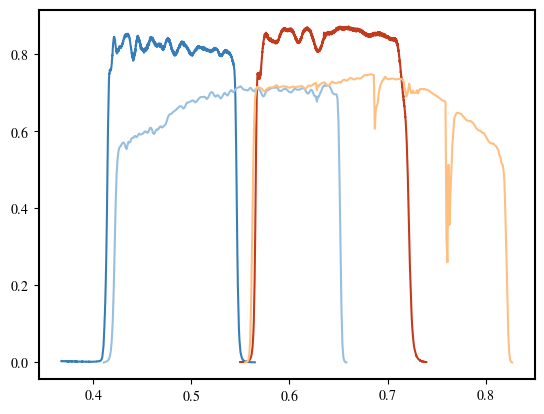

In [3]:
plt.plot(transs['ztfg'][0]/1e4,transs['ztfg'][1],c=dcolors[0])
plt.plot(transs['ztfr'][0]/1e4,transs['ztfr'][1],c=dcolors[7])

plt.plot(transs['atlasc'][0]/1e4,transs['atlasc'][1],c=lcolors[0])
plt.plot(transs['atlaso'][0]/1e4,transs['atlaso'][1],c=lcolors[1])

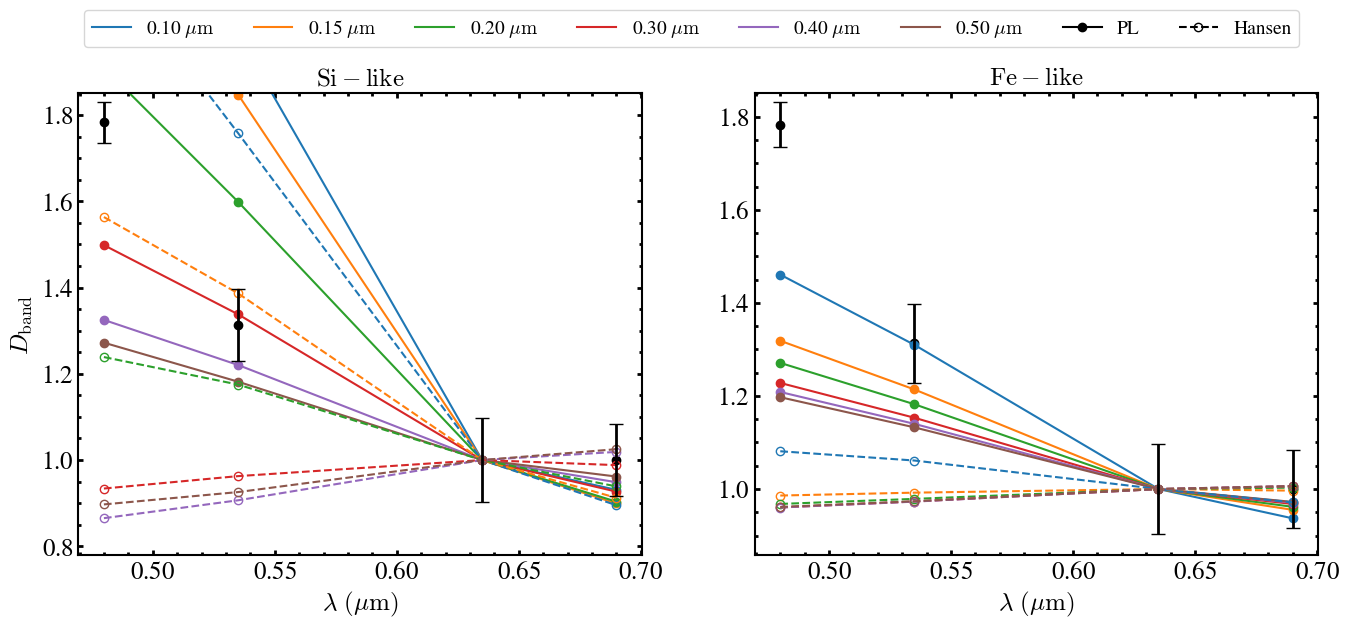

In [4]:
%matplotlib inline

################################################################################################################
# Code to Generate Figure 9 in paper
################################################################################################################

# The order followed is from blue to red central wavelength: ZTF_g, ATLAS_c, ZTF_r, ATLAS_o

# The central wavelengths of the bands
band_mean = np.array([0.48, 0.535, 0.635, 0.69])

# The inferred depths (as in Figure 8) normalized to the ZTF_r band
inf_ratios = np.array([0.296, 0.218, 0.166, 0.166])/0.166

# The errors in the inferred depths relative to ZTF_r band
inf_ratios_err = np.array([0.004, 0.007, 0.008, 0.007])/0.166

# Creating the Figure
figa = plt.figure('a',figsize=(16,6))
gsa = GridSpec(1,2,hspace=0)
ax = figa.add_subplot(gsa[0,0])

#################################################################################
# Si-like RI Case
#################################################################################

# Defining the list of sizes
sizes = [0.10,0.15,0.20,0.30,0.40,0.50]

# Defining the refractive index
k =1.7-0.03j

# Defining the index for the PL distribution
ind = 3.5

# Define a range of lambda for interpolation purpose
lambdas = np.linspace(0.35,0.90,100)
col=0

#########################
# PL distribution
#########################

# Run the loop on the particle sizes
for size in sizes:
    rmax = size # The maximum radius is the size parameter
    
    # Here, we do a polyniomial approximation to mean sigma (Eq 11, pardon the mis-label of the variable)
    qmean = []
    
    # Loop over the lambda grid
    for lamb in lambdas:
        # Calculate Eq 11 for each of the lambdas (rmin = 0.01 micron for PL, see text)
        qmean.append(quad(mie_part_dist, 0.01, rmax, args=(lamb, k, 3.5))[0]/quad(part_dist, 0.01, rmax, args=(3.5))[0])
    
    # Fit deg = 3 polyniomial
    qmean_poly = np.polyfit(lambdas, qmean, deg=3)

    # Function to evaluate integrand of the numerator of Equation 12
    def bb_qmean(w, fil):
        b = np.interp(w, fit_wave, fit_flux)
        qm = np.polyval(qmean_poly, w)
        trans_frac = np.interp(w, transs[fil][0]/10000, transs[fil][1])
        return b*qm*w*trans_frac
    
    # Calculate the D_band/N for all the bands (Equation 12)
    # The wavelength range of integration has been set to the approximate lower and upper range of the bands for convenience
    ztf_g_ratio = quad(bb_qmean, 0.41, 0.55, limit=20000, args=('ztfg'))[0]/quad(black, 0.41, 0.55, limit=20000, args=('ztfg'))[0]
    ztf_r_ratio = quad(bb_qmean, 0.55, 0.74, limit=20000, args=('ztfr'))[0]/quad(black, 0.55, 0.74, limit=20000, args=('ztfr'))[0]
    atlas_c_ratio = quad(bb_qmean, 0.41, 0.66, limit=20000, args=('atlasc'))[0]/quad(black, 0.41, 0.66, limit=20000, args=('atlasc'))[0]
    atlas_o_ratio = quad(bb_qmean, 0.55, 0.83, limit=20000, args=('atlaso'))[0]/quad(black, 0.55, 0.83, limit=20000, args=('atlaso'))[0]
    ratios = np.array([ztf_g_ratio, atlas_c_ratio, ztf_r_ratio, atlas_o_ratio])
    
    # Normalize the ratios to that of ZTF_r band
    ax.plot(band_mean, ratios*(1/ztf_r_ratio), marker='o',c='C'+str(col))
    
    # Plot a buffer line for label
    ax.plot([0.55,0.56], [2,2.1], c='C'+str(col), label=str(format(size, '.2f'))+r' $\mu {\rm m}$')
    col=col+1
    
#########################
# Hansen distribution
#########################

# Same code as PL distribution, except here size parameter represents the r_eff in Eq 14
# The lower and upper limits of integration has been set at 0.001 and 10 microns respectively (and not 0 and inf)..
# ..for reasons of computation. Manual inspection showed that these limits work well
# nu_eff in Eq 14 has been fixed at 0.1 (see text)

col=0
for size in sizes:
    reff = size
    qmean = []
    for lamb in lambdas:
        qmean.append(quad(mie_part_dist_2, 0.001, 10, args=(lamb, k, reff, 0.1))[0]/quad(part_dist_2, 0.001, 10, args=(reff, 0.1))[0])
    qmean_poly = np.polyfit(lambdas, qmean, deg=3)

    def bb_qmean(w, fil):
        b = np.interp(w, fit_wave, fit_flux)
        qm = np.polyval(qmean_poly, w)
        trans_frac = np.interp(w, transs[fil][0]/10000, transs[fil][1])
        return b*qm*w*trans_frac
    
    ztf_g_ratio = quad(bb_qmean, 0.41, 0.55, limit=20000, args=('ztfg'))[0]/quad(black, 0.41, 0.55, limit=20000, args=('ztfg'))[0]
    ztf_r_ratio = quad(bb_qmean, 0.55, 0.74, limit=20000, args=('ztfr'))[0]/quad(black, 0.55, 0.74, limit=20000, args=('ztfr'))[0]
    atlas_c_ratio = quad(bb_qmean, 0.41, 0.66, limit=20000, args=('atlasc'))[0]/quad(black, 0.41, 0.66, limit=20000, args=('atlasc'))[0]
    atlas_o_ratio = quad(bb_qmean, 0.55, 0.83, limit=20000, args=('atlaso'))[0]/quad(black, 0.55, 0.83, limit=20000, args=('atlaso'))[0]
    ratios = np.array([ztf_g_ratio, atlas_c_ratio, ztf_r_ratio, atlas_o_ratio])
    ax.plot(band_mean, ratios*(1/ztf_r_ratio), linestyle='--',c='C'+str(col), marker='o', markerfacecolor='None')
    col=col+1

# Dummy plots for labels
ax.plot([0.55,0.56], [2,2.1], c='k', label='PL', marker='o')
ax.plot([0.55,0.56], [2,2.1], c='k', label='Hansen', linestyle='--', marker='o', markerfacecolor='None')

# Plot the Observed values. The errors have been inflated to twice the actual value to account for underestimation
ax.errorbar(band_mean, inf_ratios, yerr=2*inf_ratios_err, marker='o', fmt=' ', c='k', barsabove=True, capsize=5, elinewidth=2)

# Labels etc
ax.set_xlabel(r'$\lambda\ (\mu {\rm m})$', fontsize = 18)
ax.set_ylabel(r'$D_{\rm band}$', fontsize = 18)
ax.minorticks_on()
ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.set_ylim(top=1.85)

ax.set_title(r'${\rm Si-like}$', fontsize=18)

ax.legend(fontsize=14, ncol=8, loc=(0.01,1.1))

#################################################################################
# Fe-like RI Case
#################################################################################

# Identical code as Si-like with modified k

ax = figa.add_subplot(gsa[0,1])

sizes = [0.10,0.15, 0.20,0.30,0.40,0.50]
k =2-2.5j
ind = 3.5
lambdas = np.linspace(0.35,0.90,100)
col=0
for size in sizes:
    rmax = size
    qmean = []
    for lamb in lambdas:
        qmean.append(quad(mie_part_dist, 0.01, rmax, args=(lamb, k, 3.5))[0]/quad(part_dist, 0.01, rmax, args=(3.5))[0])
    qmean_poly = np.polyfit(lambdas, qmean, deg=3)

    def bb_qmean(w, fil):
        b = np.interp(w, fit_wave, fit_flux)
        qm = np.polyval(qmean_poly, w)
        trans_frac = np.interp(w, transs[fil][0]/10000, transs[fil][1])
        return b*qm*w*trans_frac
    
    ztf_g_ratio = quad(bb_qmean, 0.41, 0.55, limit=20000, args=('ztfg'))[0]/quad(black, 0.41, 0.55, limit=20000, args=('ztfg'))[0]
    ztf_r_ratio = quad(bb_qmean, 0.55, 0.74, limit=20000, args=('ztfr'))[0]/quad(black, 0.55, 0.74, limit=20000, args=('ztfr'))[0]
    atlas_c_ratio = quad(bb_qmean, 0.41, 0.66, limit=20000, args=('atlasc'))[0]/quad(black, 0.41, 0.66, limit=20000, args=('atlasc'))[0]
    atlas_o_ratio = quad(bb_qmean, 0.55, 0.83, limit=20000, args=('atlaso'))[0]/quad(black, 0.55, 0.83, limit=20000, args=('atlaso'))[0]
    ratios = np.array([ztf_g_ratio, atlas_c_ratio, ztf_r_ratio, atlas_o_ratio])
    ax.plot(band_mean, ratios*(1/ztf_r_ratio), c='C'+str(col), marker='o')
    col=col+1
    
col=0
for size in sizes:
    reff = size
    qmean = []
    for lamb in lambdas:
        qmean.append(quad(mie_part_dist_2, 0.001, 10, args=(lamb, k, reff, 0.1))[0]/quad(part_dist_2, 0.001, 10, args=(reff, 0.1))[0])
    qmean_poly = np.polyfit(lambdas, qmean, deg=3)

    def bb_qmean(w, fil):
        b = np.interp(w, fit_wave, fit_flux)
        qm = np.polyval(qmean_poly, w)
        trans_frac = np.interp(w, transs[fil][0]/10000, transs[fil][1])
        return b*qm*w*trans_frac
    
    ztf_g_ratio = quad(bb_qmean, 0.41, 0.55, limit=20000, args=('ztfg'))[0]/quad(black, 0.41, 0.55, limit=20000, args=('ztfg'))[0]
    ztf_r_ratio = quad(bb_qmean, 0.55, 0.74, limit=20000, args=('ztfr'))[0]/quad(black, 0.55, 0.74, limit=20000, args=('ztfr'))[0]
    atlas_c_ratio = quad(bb_qmean, 0.41, 0.66, limit=20000, args=('atlasc'))[0]/quad(black, 0.41, 0.66, limit=20000, args=('atlasc'))[0]
    atlas_o_ratio = quad(bb_qmean, 0.55, 0.83, limit=20000, args=('atlaso'))[0]/quad(black, 0.55, 0.83, limit=20000, args=('atlaso'))[0]
    ratios = np.array([ztf_g_ratio, atlas_c_ratio, ztf_r_ratio, atlas_o_ratio])
    ax.plot(band_mean, ratios*(1/ztf_r_ratio), linestyle='--',c='C'+str(col), marker='o', markerfacecolor='None')
    col=col+1
    
ax.errorbar(band_mean, inf_ratios, yerr=2*inf_ratios_err, marker='o', fmt=' ', c='k', barsabove=True, capsize=5, elinewidth=2)
ax.set_xlabel(r'$\lambda\ (\mu {\rm m})$', fontsize = 18)
ax.minorticks_on()
ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.set_ylim(top=1.85)

ax.set_title(r'${\rm Fe-like}$', fontsize=18)
    
################################################################################################################

#plt.savefig('grain_size_plandhansen.pdf',bbox_inches='tight')

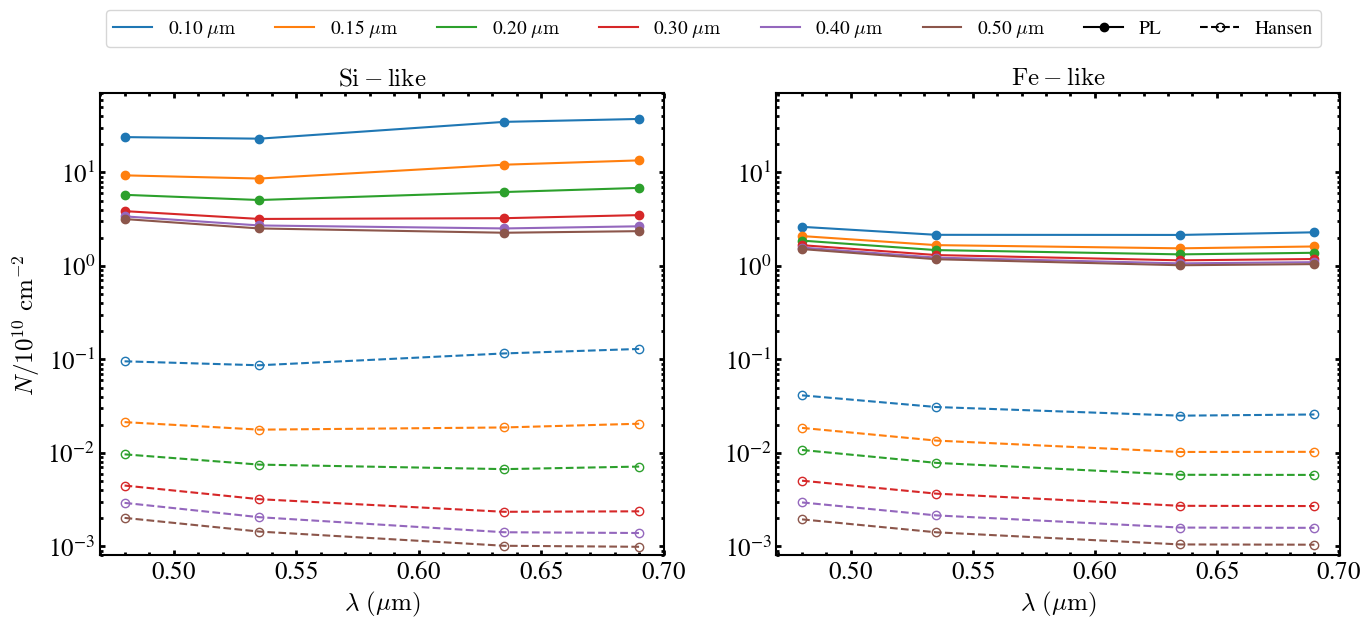

In [5]:
%matplotlib inline

################################################################################################################
# Code to Generate Figure 9 in paper
################################################################################################################

# Code to calculate column density with PL distribution
# f = D_band (the observed value)
# w1/2 = approximate wavelength bounds for the bands for convenience of the integration
# rmax = grain radius parameter (apologies for the confusing naming)
# fil = filter
def column_density(f, w1, w2, rmax, k, fil):
    
    # Polyniomial approximation of mean sigma (same as previous cell)
    qmean = []
    lambdas = np.linspace(0.35,0.90,100)
    for lamb in lambdas:
        qmean.append(quad(mie_part_dist, 0.01, rmax, args=(lamb, k, 3.5))[0]/quad(part_dist, 0.01, rmax, args=(3.5))[0])
    qmean_poly = np.polyfit(lambdas, qmean, deg=3)

    # Again same function as previous cell
    def bb_qmean(w, fil):
        b = np.interp(w, fit_wave, fit_flux)
        qm = np.polyval(qmean_poly, w)
        trans_frac = np.interp(w, transs[fil][0]/10000, transs[fil][1])
        return b*qm*w*trans_frac
    
    # D_band (again same)
    ratio = quad(bb_qmean, w1, w2, limit=2000, args=(fil))[0]/quad(black, w1, w2, limit=2000, args=(fil))[0]
    
    # Given D_band (here f), invert Eq 12 to get N 
    # f has the unit of area. In the above calculations, the area was in units of microns. 
    # 1 micron^2 = 1e-8 cm^2. This gives the factor 1e8 in the calculation
    # The final output is thus N in cm^2 units
    return (f/ratio)*1e8

# Code to calculate column density with PL distribution
# Same code as previous function, with the distribution changed
def column_density_2(f, w1, w2, rmax, k, fil):
    qmean = []
    lambdas = np.linspace(0.35,0.90,100)
    for lamb in lambdas:
        qmean.append(quad(mie_part_dist_2, 0.01, 10, args=(lamb, k, rmax, 0.1))[0]/quad(part_dist_2, 0.01, 10, args=(rmax, 0.1))[0])
    
    qmean_poly = np.polyfit(lambdas, qmean, deg=3)

    def bb_qmean(w, fil):
        b = np.interp(w, fit_wave, fit_flux)
        qm = np.polyval(qmean_poly, w)
        trans_frac = np.interp(w, transs[fil][0]/10000, transs[fil][1])
        return b*qm*w*trans_frac
    
    bb_qm_int = quad(bb_qmean, w1, w2, limit=2000, args=(fil))[0]
    bb_int = quad(black, w1, w2, limit=2000, args=(fil))[0]
    return ((f*bb_int)/bb_qm_int)*1e8

# Creating the Figure
figa = plt.figure('a',figsize=(16,6))
gsa = GridSpec(1,2,hspace=0)

#################################################################################
# Si-like RI Case
#################################################################################
ax = figa.add_subplot(gsa[0,0])

# Defining the parameters
fs = [0.296, 0.218, 0.166, 0.166]
w1s = [0.41, 0.41, 0.55, 0.55]
w2s = [0.55, 0.66, 0.74, 0.83]
fils = ['ztfg', 'atlasc', 'ztfr', 'atlaso']
band_mean = np.array([0.48, 0.535, 0.635, 0.69])

#########################
# PL distribution
#########################

rmaxs = [0.10,0.15, 0.20,0.30,0.40,0.50]

k = 1.7-0.03j
c=0
for rmax in rmaxs:
    #rmean = quad(part_dist_wgtd, 0.01, rmax, args=(3.5))[0]/quad(part_dist, 0.01, rmax, args=(3.5))[0]
    
    # Calculate the column densities for PL distribution
    cds = []
    for (f, w1, w2, fil) in zip(fs, w1s, w2s, fils):
        cds.append(column_density(f, w1, w2, rmax, k, fil))
        
    # Plot in units of 10^10 cm^2
    ax.plot(band_mean, np.array(cds)/1e10, marker='o', c='C'+str(c))
    
    # Dummy plot for label
    ax.plot([100,200], [10,20], label=str(format(rmax, '.2f'))+r' $\mu {\rm m}$', c='C'+str(c))
    c+=1
    
#########################
# Hansen distribution
#########################

rmaxs = [0.10,0.15, 0.20, 0.3, 0.4, 0.5]
c=0
for rmax in rmaxs:
    #rmean = quad(part_dist_wgtd_2, 0.01, 10, args=(rmax, 0.1))[0]/quad(part_dist_2, 0.01, 10, args=(rmax, 0.1))[0]
    
    # Same as previous, for Hansen
    cds = []
    for (f, w1, w2, fil) in zip(fs, w1s, w2s, fils):
        cds.append(column_density_2(f, w1, w2, rmax, k, fil))
    ax.plot(band_mean, np.array(cds)/1e10, linestyle='--', c='C'+str(c), marker='o', markerfacecolor='None')
    c+=1
    
# Legends and Labels
ax.plot([100,200], [10,21], c='k', label='PL', marker='o')
ax.plot([100,200], [20,21], c='k', label='Hansen', linestyle='--', marker='o', markerfacecolor='None')
    
ax.set_xlabel(r'$\lambda\ (\mu {\rm m})$', fontsize = 18)
ax.set_ylabel(r'$N/10^{10}\ {\rm cm^{-2}}$', fontsize = 18)
ax.minorticks_on()
ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.set_xlim(0.47, 0.7)
ax.set_ylim(8e-4, 7e1)
ax.set_yscale('log')

ax.set_title(r'${\rm Si-like}$', fontsize=18)

ax.legend(fontsize=14, ncol=8, loc=(0.01,1.1))

#################################################################################
# Si-like RI Case
#################################################################################
    
ax = figa.add_subplot(gsa[0,1])

#########################
# PL distribution
#########################

rmaxs = [0.10,0.15, 0.20,0.30,0.40,0.50]

k = 2-2.5j
for rmax in rmaxs:
    cds = []
    for (f, w1, w2, fil) in zip(fs, w1s, w2s, fils):
        cds.append(column_density(f, w1, w2, rmax, k, fil))
    ax.plot(band_mean, np.array(cds)/1e10, marker='o', label=str(format(rmax, '.2f'))+r' $\mu {\rm m}$')
    
#########################
# Hansen distribution
#########################
    
rmaxs = [0.10,0.15, 0.20, 0.3, 0.4, 0.5]
c=0
for rmax in rmaxs:
    #rmean = quad(part_dist_wgtd_2, 0.01, 10, args=(rmax, 0.1))[0]/quad(part_dist_2, 0.01, 10, args=(rmax, 0.1))[0]
    cds = []
    for (f, w1, w2, fil) in zip(fs, w1s, w2s, fils):
        cds.append(column_density_2(f, w1, w2, rmax, k, fil))
    ax.plot(band_mean, np.array(cds)/1e10, linestyle='--', c='C'+str(c), marker='o', markerfacecolor='None')
    c+=1
    
# Labels and Legends
    
ax.set_xlabel(r'$\lambda\ (\mu {\rm m})$', fontsize = 18)
ax.minorticks_on()
ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.set_yscale('log')
ax.set_ylim(8e-4, 7e1)

ax.set_title(r'${\rm Fe-like}$', fontsize=18)

################################################################################################################

#plt.savefig('column_density_est_withhansen.pdf',bbox_inches='tight')

# Comparison of Qext with Croll17

In [16]:
x = np.logspace(-3, 2, 500)
k1 = 1.7-0.03j
k2 = 2-2.5j
qext1, qsca, qback, g = miepython.mie(k1, x)
qext2, qsca, qback, g = miepython.mie(k2, x)

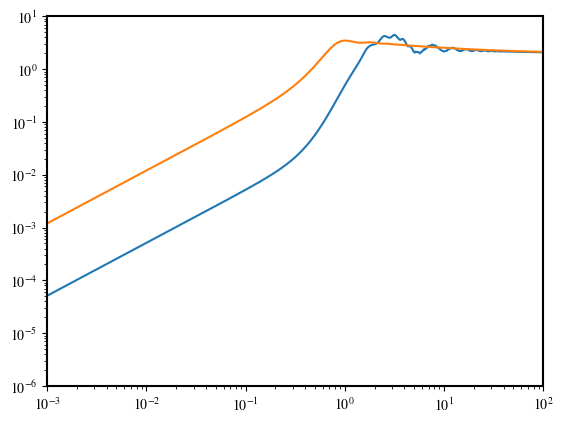

In [17]:
plt.plot(x, qext1)
plt.plot(x, qext2)
plt.ylim(1e-6, 1e1)
plt.xlim(1e-3, 1e2)
plt.yscale('log')
plt.xscale('log')